In [1]:
import os
import timeit
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

from mechaqredo.params import default_params_dict
from mechaqredo.sim import run_single_sim

In [14]:
forecast_length = 365*3
params_dict = default_params_dict(forecast_length)
params_dict

{'sim_start_datetime': datetime.datetime(2023, 7, 15, 0, 0),
 'ntxs_model': {'model': 'constant',
  'schedule': None,
  'distr': None,
  'fun': None,
  'rate': None,
  'N_trx_constant': 8000.0},
 'token_price_model': {'model': 'constant',
  'P0': 0.08,
  'drift': None,
  'sigma': None,
  'dt': 0.0027397260273972603},
 'service_fees_model': {'model': 'constant',
  'A0': 3000.0,
  'a': None,
  'mu': None,
  'sigma': None,
  'dt': 0.0027397260273972603,
  'theta': None},
 'n_validators_model': {'rate': 0.01643835616438356,
  'constant_rate': None,
  'list_of_precomputed_arrivals': None,
  'initial_number': 6},
 'new_staker_inflow_model': {'model': 'constant',
  'init_stake_amt': 1000.0,
  'rate': None},
 'previous_funds_vesting_spec': {'seed': {'vest_period_days': 7,
   'vest_end_date': datetime.datetime(2024, 7, 14, 0, 0),
   'vest_amount': 160230.04},
  'team_quarterly': {'vest_period_days': 91,
   'vest_end_date': datetime.datetime(2026, 1, 14, 0, 0),
   'vest_amount': 1976405.65},
  '

In [15]:
start = timeit.default_timer()
df = run_single_sim(forecast_length, params_dict)
stop = timeit.default_timer()
print("Run time for single sim: ", stop - start)
print("")
df.head()

Run time for single sim:  0.01679641699999479



,iteration,circ_supply,day_burned_vec,day_vested_vec,day_locked_vec,day_released_vec,vested_vec_from_staking,total_staking_rewards_vec,validators_rewards_vec,day_inflation,market_cap,day_burn_fees_vec,day_service_fee_locked_vec,ecosystem_fund_vec,n_txs_vec,token_price_vec,service_fees_vec,n_val_vec
0,0,5.349878e+08,350000004.0,0.000000e+00,1.224375e+04,1.750000e+08,0.000000,0.000000e+00,0.000000e+00,NaN,4.279902e+07,4.0,11193.75,1.100000e+08,8000.0,0.08,3000.0,6.0
1,1,5.462307e+08,4.0,2.551592e+05,1.219375e+04,1.100000e+07,94929.132588,1.109493e+07,5.547465e+06,0.021015,4.369846e+07,4.0,11193.75,9.901119e+07,8000.0,0.08,3000.0,6.0
2,2,5.534408e+08,4.0,9.488407e+04,2.785926e+06,9.901121e+06,94884.074887,9.996003e+06,4.998002e+06,0.013200,4.427526e+07,4.0,11193.75,8.912126e+07,8000.0,0.08,3000.0,6.0
3,3,5.599366e+08,4.0,9.483904e+04,2.511195e+06,8.912128e+06,94839.038572,9.006965e+06,4.503483e+06,0.011737,4.479492e+07,4.0,11193.75,8.022033e+07,8000.0,0.08,3000.0,6.0
4,4,5.709458e+08,4.0,5.251131e+06,2.263935e+06,8.022035e+06,94794.023634,8.116827e+06,4.058413e+06,0.019662,4.567566e+07,4.0,11193.75,7.220949e+07,8000.0,0.08,3000.0,6.0


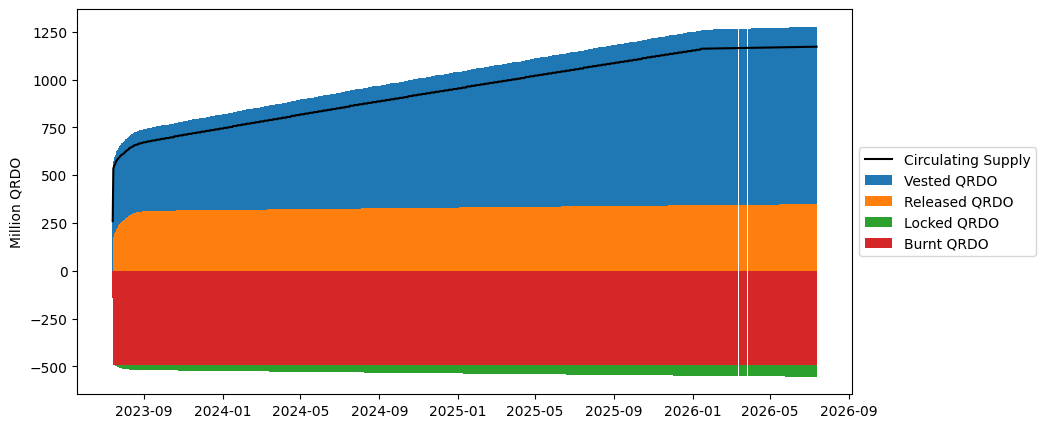

In [16]:
# Get values before sim
circ_supply_0 = np.array([params_dict["circ_supply_zero"]])
cum_burn_0 = np.array([140_000_000.0])
cum_vest_0 = np.array([params_dict["circ_supply_zero"]+140_000_000])
cum_lock_0 = np.array([0.0])
cum_release_0 = np.array([0.0])
date_0 = np.array([params_dict["sim_start_datetime"]-dt.timedelta(days=1)], dtype='datetime64[ns]')

# Build data vectors
circ_supply_vec = np.concatenate([circ_supply_0, df["circ_supply"].values])/ 10 ** 6
cum_burn_vec = np.concatenate([cum_burn_0, df["day_burned_vec"].values]).cumsum()/ 10 ** 6
cum_vest_vec = np.concatenate([cum_vest_0, df["day_vested_vec"].values]).cumsum()/ 10 ** 6
cum_lock_vec = np.concatenate([cum_lock_0, df["day_locked_vec"].values]).cumsum()/ 10 ** 6
cum_release_vec = np.concatenate([cum_release_0, df["day_released_vec"].values]).cumsum()/ 10 ** 6
temp_date_vec = df["iteration"].apply(lambda x: params_dict["sim_start_datetime"]+dt.timedelta(days=x)).values
date_vec = np.concatenate([date_0, temp_date_vec])

# Plot supply
plt.figure(figsize=(10,5))
bar_width = 0.999
plt.bar(date_vec, cum_vest_vec+cum_release_vec, label="Vested QRDO",width=bar_width)
plt.bar(date_vec, cum_release_vec, label='Released QRDO',width=bar_width)
plt.bar(date_vec, -cum_lock_vec-cum_burn_vec, label="Locked QRDO",width=bar_width)
plt.bar(date_vec, -cum_burn_vec, label="Burnt QRDO",width=bar_width)
plt.plot(date_vec, circ_supply_vec, label="Circulating Supply", c="black")
plt.ylabel("Million QRDO")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()